# ÖDEV 1: PCA yardımı ile Classification,

Bu ödevde "Credit Risk Prediction" veri setini kullanacağız. Amacımız, verinin boyut sayısını düşürerek olabildiğince yüksek accuracy değerini alabilmek. Aşağıda verinin okunma ve temizlenme kısmını hazırlayıp vereceğim. Devamında ise yapmanız gerekenler:

1. PCA kullanarak verinin boyutunu düşürmek
    * Önce explained varience ratio değerini inceleyerek veriyi kaç boyuta düşürebileceğini kontrol et.
    * Daha sonra farklı boyutlarda denemeler yaparak boyutu düşürülmüş verileri elde et.
2. Classification modellerini dene
    * Logistic Regression
    * Random Forest
    * ve eğer istersen herhangi bir modelle daha

İsteğe bağlı olarak, verinin boyutunu düşürmek için diğer yöntemleri de kullanıp en yüksek accuracy değerini almayı deneyebilirsin.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df: pd.DataFrame = pd.read_csv('./credit_risk_dataset.csv')

In [4]:
print(df.isnull().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [5]:
# Null değerleri sütun ortalaması ile dolduruyoruz
df["person_emp_length"].fillna(df["person_emp_length"].median(), inplace=True)
df["loan_int_rate"].fillna(df["loan_int_rate"].median(), inplace=True)

In [6]:
df.duplicated().sum()

165

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32416.0,27.747008,6.354100,20.00,23.00,26.00,30.00,144.00
person_income,32416.0,66091.640826,62015.580269,4000.00,38542.00,55000.00,79218.00,6000000.00
person_emp_length,32416.0,4.768880,4.090411,0.00,2.00,4.00,7.00,123.00
loan_amnt,32416.0,9593.845632,6322.730241,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,32416.0,11.014662,3.083050,5.42,8.49,10.99,13.11,23.22
loan_status,32416.0,0.218688,0.413363,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32416.0,0.170250,0.106812,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32416.0,5.811297,4.059030,2.00,3.00,4.00,8.00,30.00


In [9]:
# Outlier temizliği
df = df[df['person_age']<=100]
df = df[df['person_emp_length'] <= 60]
df = df[df['person_income']<=4e6]

In [10]:
# Kategorik verileri alıyoruz ve one hot encoding haline getiriyoruz
cat_cols = pd.DataFrame(df[df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [11]:
encoded_cat_cols = pd.get_dummies(cat_cols)
df.drop(df.select_dtypes(include=['object']).columns, axis=1,inplace=True)
df = pd.concat([df,encoded_cat_cols], axis=1)

In [12]:
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

In [13]:
# Verileri train ve test olarak ikiye ayırıyoruz

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(1, test_size=0.1)
train_idx, test_idx = next(split.split(X, y))
train_x = X[train_idx]
test_x = X[test_idx]

train_y = y[train_idx]
test_y = y[test_idx]

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA()
pca.fit(X)


PCA()

In [16]:
cumsum_data=np.cumsum(pca.explained_variance_ratio_)
cumsum_data

array([0.98717238, 0.99999997, 0.99999999, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

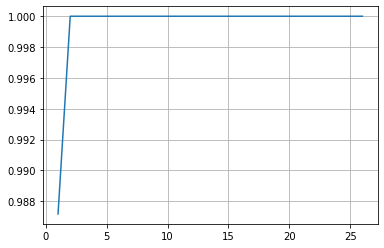

In [17]:
# it is clear that 3D enough to describe our data 
# lets visualize  
x_tick = np.arange(1,len(cumsum_data)+1, 1)
plt.grid(True)
plt.plot(x_tick, cumsum_data)

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [19]:
LR=LogisticRegression()
RF=RandomForestClassifier()
# train with normal data to compare pca data
LR.fit(train_x,train_y)
predict_LR=LR.predict(test_x)
accuracy_LR=accuracy_score(predict_LR,test_y)

RF.fit(train_x,train_y)
predict_RF=RF.predict(test_x)
accuracy_RF=accuracy_score(predict_RF,test_y)

print(f"Logistic Regression Accuracy :{accuracy_LR} \nRandom Forest Accuracy: {accuracy_RF}")


Logistic Regression Accuracy :0.7982104288799753 
Random Forest Accuracy: 0.9355137303301451


In [20]:
# lets train random forest, logistic regression with different dimension  

all_accuracy=[]
for i in range(1,6):
    LR=LogisticRegression()
    RF=RandomForestClassifier()
    pca=PCA(n_components=i)
    new_train=pca.fit_transform(X[train_idx])
    new_test=pca.fit_transform(X[test_idx])

    LR.fit(new_train,train_y)
    prediction_LR=LR.predict(new_test)
    accuracy_LR=accuracy_score(predict_LR,test_y)

    RF.fit(new_train,train_y)
    predict_RF=RF.predict(new_test)
    accuracy_RF=accuracy_score(predict_RF,test_y)

    all_accuracy.append(accuracy_LR)
    all_accuracy.append(accuracy_RF)
    print(f"with{i} dimension data  accuracy scores: \n Logistic Regression Accuracy :{accuracy_LR} \n Random Forest Accuracy: {accuracy_RF}")

with1 dimension data  accuracy scores: 
 Logistic Regression Accuracy :0.7982104288799753 
 Random Forest Accuracy: 0.6747917309472385
with2 dimension data  accuracy scores: 
 Logistic Regression Accuracy :0.7982104288799753 
 Random Forest Accuracy: 0.8188830607837088
with3 dimension data  accuracy scores: 
 Logistic Regression Accuracy :0.7982104288799753 
 Random Forest Accuracy: 0.826288182659673
with4 dimension data  accuracy scores: 
 Logistic Regression Accuracy :0.7982104288799753 
 Random Forest Accuracy: 0.8444924406047516


C:\Users\Pain\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


with5 dimension data  accuracy scores: 
 Logistic Regression Accuracy :0.7982104288799753 
 Random Forest Accuracy: 0.8642394322739895


In [21]:
# even pca data contain normal data random forest give worse result , it means  random forest  need more node to desribe the data